In [11]:
import glob
import torch
from torch.utils import data
from PIL import Image
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt


/home/ansonhon/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#通过创建data.Dataset子类Mydataset来创建输入
class Mydataset(data.Dataset):
# 类初始化
    def __init__(self, root):
        self.imgs_path = root
# 进行切片
    def __getitem__(self, index):
        img_path = self.imgs_path[index]
        return img_path
# 返回长度
    def __len__(self):
        return len(self.imgs_path)


In [3]:
#使用glob方法来获取数据图片的所有路径
all_imgs_path = glob.glob(r'/home/lyc/doc/AML_LAB/dataset(png)/*/*.png')#数据文件夹路径，根据实际情况更改！
#循环遍历输出列表中的每个元素，显示出每个图片的路径
for var in all_imgs_path:
    print(var)

#利用自定义类Mydataset创建对象weather_dataset
signature_dataset = Mydataset(all_imgs_path)
print(len(signature_dataset)) #返回文件夹中图片总个数
print(signature_dataset[12:15])#切片，显示第12至第十五张图片的路径
sinature_datalodaer = torch.utils.data.DataLoader(signature_dataset, batch_size=5) #每次迭代时返回五个数据
print(next(iter(sinature_datalodaer)))

species = ['false','true']
species_to_id = dict((c, i) for i, c in enumerate(species))
print(species_to_id)
id_to_species = dict((v, k) for k, v in species_to_id.items())
print(id_to_species)
all_labels = []
#对所有图片路径进行迭代
for img in all_imgs_path:       # img = file path of type string
    # 区分出每个img，应该属于什么类别
    for idx, category in enumerate(species):
        if category in img:             # If the string 'false' or the string "true" is in the file path
            all_labels.append(idx)
print(all_labels) #得到所有标签


/home/lyc/doc/AML_LAB/dataset(png)/false/false_2.png
/home/lyc/doc/AML_LAB/dataset(png)/false/false_1.png
/home/lyc/doc/AML_LAB/dataset(png)/false/false_3.png
/home/lyc/doc/AML_LAB/dataset(png)/false/false_5.png
/home/lyc/doc/AML_LAB/dataset(png)/false/false_4.png
/home/lyc/doc/AML_LAB/dataset(png)/true/true_3.png
/home/lyc/doc/AML_LAB/dataset(png)/true/true_4.png
/home/lyc/doc/AML_LAB/dataset(png)/true/true_2.png
/home/lyc/doc/AML_LAB/dataset(png)/true/true_1.png
/home/lyc/doc/AML_LAB/dataset(png)/true/true_5.png
10
[]
['/home/lyc/doc/AML_LAB/dataset(png)/false/false_2.png', '/home/lyc/doc/AML_LAB/dataset(png)/false/false_1.png', '/home/lyc/doc/AML_LAB/dataset(png)/false/false_3.png', '/home/lyc/doc/AML_LAB/dataset(png)/false/false_5.png', '/home/lyc/doc/AML_LAB/dataset(png)/false/false_4.png']
{'false': 0, 'true': 1}
{0: 'false', 1: 'true'}
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]


torch.Size([10, 3, 240, 320])


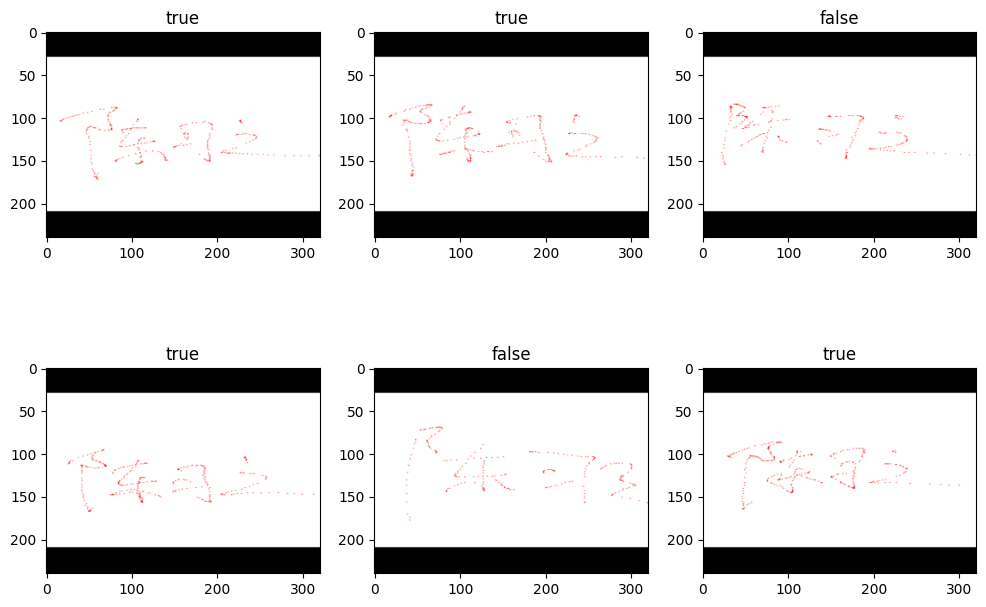

In [4]:
# 对数据进行转换处理
transform = transforms.Compose([
                transforms.Resize((240,320)), #做的第一步转换
                transforms.ToTensor() #第二步转换，作用：第一转换成Tensor，第二将图片取值范围转换成0-1之间，第三会将channel置前
])

class Mydatasetpro(data.Dataset):
# 类初始化
    def __init__(self, img_paths, labels, transform):
        self.imgs = img_paths
        self.labels = labels
        self.transforms = transform
# 进行切片
    def __getitem__(self, index):                #根据给出的索引进行切片，并对其进行数据处理转换成Tensor，返回成Tensor
        img = self.imgs[index]
        label = self.labels[index]
        pil_img = Image.open(img)                 #pip install pillow
        data = self.transforms(pil_img)
        return data, label
# 返回长度
    def __len__(self):
        return len(self.imgs)

BATCH_SIZE = 10
signature_dataset = Mydatasetpro(all_imgs_path, all_labels, transform)
sinature_datalodaer = data.DataLoader(
                            signature_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True
)

imgs_batch, labels_batch = next(iter(sinature_datalodaer))
print(imgs_batch.shape)

plt.figure(figsize=(12, 8))
for i, (img, label) in enumerate(zip(imgs_batch[:6], labels_batch[:6])):
    img = img.permute(1, 2, 0).numpy()
    plt.subplot(2, 3, i+1)
    plt.title(id_to_species.get(label.item()))
    plt.imshow(img)
plt.show()#展示图片


In [5]:
#划分测试集和训练集
index = np.random.permutation(len(all_imgs_path))

all_imgs_path = np.array(all_imgs_path)[index]
all_labels = np.array(all_labels)[index]

#80% as train
s = int(len(all_imgs_path)*0.7)
print(s)

train_imgs = all_imgs_path[:s]
train_labels = all_labels[:s]
test_imgs = all_imgs_path[s:]
test_labels = all_labels[s:]
print(test_labels)
train_ds = Mydatasetpro(train_imgs, train_labels, transform) #TrainSet TensorData
test_ds = Mydatasetpro(test_imgs, test_labels, transform) #TestSet TensorData
train_dl = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)#TrainSet Labels
test_dl = data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)#TestSet Labels


7
[1 0 0]


## 训练

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader

# 假设您的数据集已经准备好，包括训练集和验证集
# 这里仅作示例，您需要根据实际情况修改数据加载部分
fefe
fatal: need to specify how to reconcile divergent branches.


# 初始化ResNet模型
model = resnet18(pretrained=True)
num_classes = 2
model.fc = nn.Linear(model.fc.in_features, num_classes)

# 设置优化器和损失函数
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 训练模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(50):  # 假设训练10个epoch
    model.train()
    running_loss = 0.0
    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)  # 将图像和标签分别移动到设备上
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/10], Loss: {running_loss / len(train_dl)}")

# 验证模型
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)  # 将图像和标签分别移动到设备上
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")


/home/lyc/anaconda3/envs/mix/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lyc/anaconda3/envs/mix/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.9703859090805054
Epoch [2/10], Loss: 0.08015215396881104
Epoch [3/10], Loss: 0.00030438462272286415
Epoch [4/10], Loss: 0.00010566392302280292
Epoch [5/10], Loss: 7.562562677776441e-05
Epoch [6/10], Loss: 7.174230267992243e-05
Epoch [7/10], Loss: 7.715594983892515e-05
Epoch [8/10], Loss: 8.929488103603944e-05
Epoch [9/10], Loss: 0.00010444690269650891
Epoch [10/10], Loss: 0.0001199904436361976
Epoch [11/10], Loss: 0.00013544892135541886
Epoch [12/10], Loss: 0.00015031184011604637
Epoch [13/10], Loss: 0.0001650210760999471
Epoch [14/10], Loss: 0.00017901496903505176
Epoch [15/10], Loss: 0.0001924121897900477
Epoch [16/10], Loss: 0.00020517849770840257
Epoch [17/10], Loss: 0.00021591833501588553
Epoch [18/10], Loss: 0.0002239684108644724
Epoch [19/10], Loss: 0.00022822295431979
Epoch [20/10], Loss: 0.00022812078532297164
Epoch [21/10], Loss: 0.0002240873727714643
Epoch [22/10], Loss: 0.00021750087034888566
Epoch [23/10], Loss: 0.00020941633556503803
Epoch [24/10], L